In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, LeaveOneOut, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, svm

from itertools import combinations
from textwrap import wrap

# Exploring covariance between properties across scales
**Authors**: Benjamin Jasperson, Harley T. Johnson

**GitHub URL**: https://github.com/bjasperson/property-covariance-demo

# Background Information

why
compromise on modeling: accuracy/first-principles vs. speed and domain size.

what

goals

We're interested in uncovering relationships between fundamental microscopic properties and GB energy.
Desire a scalar value to compare against.
Derived a scaling coefficient.
For purposes here, you don't need to worry about how this coefficient is defined (see the paper for details).

# Download Data
To begin, we need to import our project data.
Collecting this data ....

The data we will use is originally from [this manuscript](https://arxiv.org/abs/2411.16770), [published here](https://doi.org/10.1016/j.actamat.2025.120722). You can find the original paper repo [here](https://github.com/Johnson-Research-Group/gb_covariance).

**Task**: Using pandas, download the CSV file with this [link](https://github.com/bjasperson/property-covariance-demo/blob/main/data/gb_data.csv?raw=true) and look at the first five rows.

In [2]:
url_link = "https://github.com/bjasperson/property-covariance-demo/blob/main/data/gb_data.csv?raw=true"
df_data = pd.read_csv(url_link, index_col=0)
df_data.head()

,crystal_type,species,model,lattice_constant_bcc,lattice_constant_fcc,lattice_constant_sc,bulk_modulus_bcc,bulk_modulus_fcc,bulk_modulus_sc,c44_bcc,...,unrelaxed_formation_potential_energy_fcc,unrelaxed_formation_potential_energy_hcp,vacancy_migration_energy_bcc,vacancy_migration_energy_fcc,vacancy_migration_energy_hcp,vacancy_migration_energy_sc,relaxation_volume_bcc,relaxation_volume_fcc,relaxation_volume_hcp,coeff
0,fcc,Al,Sim_LAMMPS_MEAM_PascuetFernandez_2015_AlU__SM_...,3.270778,4.049999,2.740228,54.825677,78.890189,46.023445,34.077157,...,1.058020,NaN,NaN,0.610757,NaN,NaN,NaN,4.683538,NaN,1.191668
1,fcc,Al,Sim_LAMMPS_MEAM_PascuetFernandez_2015_Al__SM_8...,3.270778,4.049999,2.740228,54.825677,78.890189,46.023445,34.077157,...,1.058020,NaN,NaN,0.610485,NaN,NaN,NaN,4.681808,NaN,1.191794
2,fcc,Al,Sim_LAMMPS_MEAM_AlmyrasSangiovanniSarakinos_20...,3.252540,4.047000,2.581950,71.601330,79.371087,61.759057,26.806281,...,1.383830,NaN,NaN,0.573611,NaN,NaN,NaN,5.431662,NaN,0.691561
3,fcc,Al,Sim_LAMMPS_MEAM_JelinekGrohHorstemeyer_2012_Al...,3.205723,4.049999,2.702319,81.620977,77.446258,51.141824,30.342210,...,0.841906,NaN,NaN,0.496487,NaN,NaN,NaN,5.362940,NaN,1.134840
4,fcc,Al,EAM_Dynamo_AngeloMoodyBaskes_1995_NiAlH__MO_41...,3.367689,4.050000,2.705041,83.092686,79.372122,86.368413,21.444173,...,0.746775,NaN,NaN,0.179855,NaN,NaN,NaN,5.521970,NaN,0.495295


# Data review
It is important to get a feel for the data that you are working with. 

**Task**: import the label csv file, located at `./data/label_dict.csv`. Convert it to a dictionary for use with plotting.

In [3]:
def import_label_dict(label_dict_path = "https://github.com/bjasperson/property-covariance-demo/blob/main/data/label_dict.csv?raw=true"):
    """import the ./data/label_dict.csv file, convert it to a dictionary

    Args:
        label_dict_path (str, optional): path to csv file with key/value pairs. Defaults to "./data/label_dict.csv".

    Returns:
        dict: a dictionary with df column names as keys, and human-readable label as value
    """
    
    # useful for plotting purposes
    df_label_dict = pd.read_csv(label_dict_path)
    label_dict = df_label_dict.to_dict(orient="records")[0]
    return label_dict

We now want to look at how the different fundamental properties relate with each other and our Quantity of Interest (GB energy coefficient). To do this, we need to create a plotting function.

**Task**: create a function to plot a set of parameters from the dataframe using Seaborn pairplot. Explore different combinations of pairplots for the data.

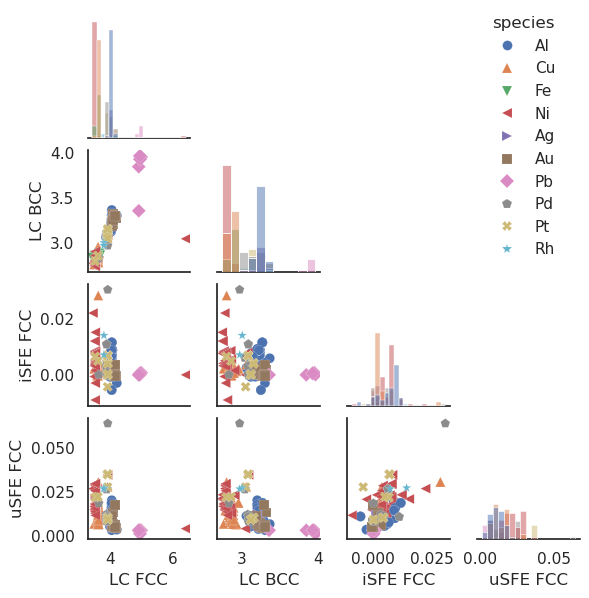

In [4]:
def pairplot_fun(df, 
                 params_list,  
                 label_dict, 
                 height=1.5,
                 #xlims = False, 
                 ):
    """create pairplot for select indicator properties

    Args:
        df (pandas.DataFrame): dataframe of data that was previously imported
        params_list (list): list of parameter strings to use
        label_dict (dict): the label dict from above, to convert label keys to human readable format
        height (float): pairplot height. Defaults to 2.0.
        xlims (list): list of limits to use for plotting
    """
    params_list.extend(['species'])
    X = df[params_list]
    X.columns = [label_dict[x] for x in X.columns.to_list()]
    sns.set_theme(style="white", font_scale = 1)
    marker_list = ['o','^','v','<','>','s','D','p','X','*','.','P']
    g = sns.pairplot(X, hue='species', corner=True, markers = marker_list[0:len(df.species.drop_duplicates())],
                     plot_kws=dict(s=50, linewidth=0.1, rasterized = True), 
                     height=height,
                     diag_kind='hist')
    sns.move_legend(g, "upper right", bbox_to_anchor = (0.85,1))

    # if xlims != False:
    #     for i in range(len(g.axes)):
    #         for j in range(len(g.axes[i])):
    #             g.axes[i][j].set_xlim(xlims)
    #             g.axes[i][j].set_ylim(xlims)


label_dict = import_label_dict()
plot_param_list = ["lattice_constant_fcc", "lattice_constant_bcc", 'intr_stack_fault_energy_fcc', 'unstable_stack_energy_fcc']
pairplot_fun(df_data, plot_param_list, label_dict)

# Identifying indicator properties

**Task**: run K-fold cross-validation. 

# Develop regression model
Linear regression versus SVR.

**Task**: Write a function that returns a linear regression pipeline. It should include:
- StandardScaler: for scaling the input values; helpful for SVR, used in LR for consistency. 
- KNNImputer: for filling in the missing property values in our data. Set `n_neighbors=2` and `keep_empty_features=True`
- LinearRegression: the linear regression model.
Combine these in a `Pipeline` to facilitate easy use .

In [5]:
def linear_regr_pipeline():
    """creates a linear regression pipeline for modeling purposes

    Returns:
        sklearn.pipeline.Pipeline: linear regression pipeline
    """

    # Linear regression selection pipeline, used in manuscript
    imput = KNNImputer(n_neighbors=2,
                       keep_empty_features=True)
    model = linear_model.LinearRegression()

    pipe = Pipeline(steps=[('scale', StandardScaler()),
                            ('imp', imput),
                            ('lr', model)])
    return pipe

pipe = linear_regr_pipeline()

Now, we need to make a list of the properties we are interested in considering as indicator properties for our model. A starting point is provided below.

**If time**: explore different properties, and see if any new additions result in improved models!

In [6]:
# list of parameters to explore
params_list = ['lattice_constant_fcc',
                'bulk_modulus_fcc', 'c11_fcc', 'c12_fcc', 'c44_fcc',
                'extr_stack_fault_energy_fcc', 'intr_stack_fault_energy_fcc', 'unstable_stack_energy_fcc'
                ]

Using the parameter list, we want to make a list of possible combinations up to a certain number of factors. 

**Task**: write a function that uses the `combinations` package to make a list of lists, with possible combinations of factors up to `n_factor_max`.

In [7]:
def create_subsets_list(factor_list, n_factor_max):
    subsets = []
    for n in range(1, (n_factor_max+1)):
        for subset in combinations(factor_list, n):
            subsets.append(list(subset))
    return subsets

subsets = create_subsets_list(params_list, n_factor_max = 2)
print(subsets)

[['lattice_constant_fcc'], ['bulk_modulus_fcc'], ['c11_fcc'], ['c12_fcc'], ['c44_fcc'], ['extr_stack_fault_energy_fcc'], ['intr_stack_fault_energy_fcc'], ['unstable_stack_energy_fcc'], ['lattice_constant_fcc', 'bulk_modulus_fcc'], ['lattice_constant_fcc', 'c11_fcc'], ['lattice_constant_fcc', 'c12_fcc'], ['lattice_constant_fcc', 'c44_fcc'], ['lattice_constant_fcc', 'extr_stack_fault_energy_fcc'], ['lattice_constant_fcc', 'intr_stack_fault_energy_fcc'], ['lattice_constant_fcc', 'unstable_stack_energy_fcc'], ['bulk_modulus_fcc', 'c11_fcc'], ['bulk_modulus_fcc', 'c12_fcc'], ['bulk_modulus_fcc', 'c44_fcc'], ['bulk_modulus_fcc', 'extr_stack_fault_energy_fcc'], ['bulk_modulus_fcc', 'intr_stack_fault_energy_fcc'], ['bulk_modulus_fcc', 'unstable_stack_energy_fcc'], ['c11_fcc', 'c12_fcc'], ['c11_fcc', 'c44_fcc'], ['c11_fcc', 'extr_stack_fault_energy_fcc'], ['c11_fcc', 'intr_stack_fault_energy_fcc'], ['c11_fcc', 'unstable_stack_energy_fcc'], ['c12_fcc', 'c44_fcc'], ['c12_fcc', 'extr_stack_fault_e

We now have our list of possible factor combinations to consider. If we fit our model to the entire dataset, we aren't getting a realistic picture of the test error. So, we will use the `cross_val_score` package from scikit-learn to perform cross validation. Read more about it [here](https://scikit-learn.org/stable/modules/cross_validation.html).

**Task**: write a function that iterates over each subset of the possible factor combinations. For each subset, use the `cross_val_score` package to perform cross-validation and return a score. 

In [8]:
def factor_select_cv(df, factors, pipe, subsets, label="coeff", cv=5, scoring='r2'):
    """evaluates combinations of factors
    
    return a dataframe that includes one row per factor combination. list of parameters w/ cv score
    """
    X = df[factors]
    y = df[label]
    
    cv_score_mean = []
    cv_score_std = []
    num_factors = []
    for i, subset in enumerate(subsets):
        print(f"{i} of {len(subsets)}")
        print('current subset: ', subset)
        score = cross_val_score(pipe, X[subset], y, cv=cv, scoring=scoring, n_jobs = -1)
        print('score mean: ', np.mean(score))
        cv_score_mean.append(np.mean(score))
        cv_score_std.append(np.std(score))
        num_factors.append(len(subset))

    df_results = pd.DataFrame({'factors': subsets,
                               'num_factors': num_factors,
                               'cv_score': cv_score_mean,
                               'cv_score_std': cv_score_std})
    df_results = df_results.sort_values('cv_score', ascending=False)

    return df_results

In [9]:
# pipe = TransformedTargetRegressor(regressor=pipe,
#                                   transformer=StandardScaler())
filename = "kfold_models_lr"

cv = RepeatedKFold(n_splits=10, n_repeats=5)
df_results = factor_select_cv(df_data,
                              params_list,
                              pipe, 
                              subsets, 
                              cv=cv, 
                              scoring='neg_root_mean_squared_error')

0 of 36
current subset:  ['lattice_constant_fcc']
score mean:  -0.474686640780968
1 of 36
current subset:  ['bulk_modulus_fcc']
score mean:  -0.45027397224768495
2 of 36
current subset:  ['c11_fcc']
score mean:  -0.45899715571869165
3 of 36
current subset:  ['c12_fcc']
score mean:  -0.4693215174688021
4 of 36
current subset:  ['c44_fcc']
score mean:  -0.36228872329020156
5 of 36
current subset:  ['extr_stack_fault_energy_fcc']
score mean:  -0.7722007145740979
6 of 36
current subset:  ['intr_stack_fault_energy_fcc']
score mean:  -0.6040516220960135
7 of 36
current subset:  ['unstable_stack_energy_fcc']
score mean:  -0.38881691056397577
8 of 36
current subset:  ['lattice_constant_fcc', 'bulk_modulus_fcc']
score mean:  -0.3907878178327758
9 of 36
current subset:  ['lattice_constant_fcc', 'c11_fcc']
score mean:  -0.39103387034953035
10 of 36
current subset:  ['lattice_constant_fcc', 'c12_fcc']
score mean:  -0.40205994732450306
11 of 36
current subset:  ['lattice_constant_fcc', 'c44_fcc']
s

**If time**: repeat the steps above using different modeling approaches, e.g., support vector regression. Compare performance of the models, and try to understand why some perform better than others.

In [10]:
df_results.sort_values("cv_score", ascending=False)

,factors,num_factors,cv_score,cv_score_std
32,"[c44_fcc, unstable_stack_energy_fcc]",2,-0.264657,0.109752
14,"[lattice_constant_fcc, unstable_stack_energy_fcc]",2,-0.323444,0.057234
29,"[c12_fcc, unstable_stack_energy_fcc]",2,-0.337530,0.071061
26,"[c12_fcc, c44_fcc]",2,-0.344645,0.121039
17,"[bulk_modulus_fcc, c44_fcc]",2,-0.351078,0.125372
31,"[c44_fcc, intr_stack_fault_energy_fcc]",2,-0.360189,0.114965
22,"[c11_fcc, c44_fcc]",2,-0.360651,0.145305
11,"[lattice_constant_fcc, c44_fcc]",2,-0.361008,0.112243
4,[c44_fcc],1,-0.362289,0.124956
35,"[intr_stack_fault_energy_fcc, unstable_stack_e...",2,-0.370525,0.047581


Pick the top performing model and make a regression model to use. Make predictions and compare predicted versus actual.

In [11]:
def add_pred(df_in, pipe_in, factors, label="coeff"):
    X = df_in[factors]
    y = df_in[label]
    pipe_in.fit(X, y)
    y_pred = pipe_in.predict(X)
    return y_pred

df_data["coeff_pred"] = add_pred(df_data, pipe, ["c12_fcc", "c44_fcc"])

In [12]:
df_data.head()

,crystal_type,species,model,lattice_constant_bcc,lattice_constant_fcc,lattice_constant_sc,bulk_modulus_bcc,bulk_modulus_fcc,bulk_modulus_sc,c44_bcc,...,unrelaxed_formation_potential_energy_hcp,vacancy_migration_energy_bcc,vacancy_migration_energy_fcc,vacancy_migration_energy_hcp,vacancy_migration_energy_sc,relaxation_volume_bcc,relaxation_volume_fcc,relaxation_volume_hcp,coeff,coeff_pred
0,fcc,Al,Sim_LAMMPS_MEAM_PascuetFernandez_2015_AlU__SM_...,3.270778,4.049999,2.740228,54.825677,78.890189,46.023445,34.077157,...,NaN,NaN,0.610757,NaN,NaN,NaN,4.683538,NaN,1.191668,1.105830
1,fcc,Al,Sim_LAMMPS_MEAM_PascuetFernandez_2015_Al__SM_8...,3.270778,4.049999,2.740228,54.825677,78.890189,46.023445,34.077157,...,NaN,NaN,0.610485,NaN,NaN,NaN,4.681808,NaN,1.191794,1.105830
2,fcc,Al,Sim_LAMMPS_MEAM_AlmyrasSangiovanniSarakinos_20...,3.252540,4.047000,2.581950,71.601330,79.371087,61.759057,26.806281,...,NaN,NaN,0.573611,NaN,NaN,NaN,5.431662,NaN,0.691561,0.911980
3,fcc,Al,Sim_LAMMPS_MEAM_JelinekGrohHorstemeyer_2012_Al...,3.205723,4.049999,2.702319,81.620977,77.446258,51.141824,30.342210,...,NaN,NaN,0.496487,NaN,NaN,NaN,5.362940,NaN,1.134840,0.928668
4,fcc,Al,EAM_Dynamo_AngeloMoodyBaskes_1995_NiAlH__MO_41...,3.367689,4.050000,2.705041,83.092686,79.372122,86.368413,21.444173,...,NaN,NaN,0.179855,NaN,NaN,NaN,5.521970,NaN,0.495295,0.969453


**Task**: write a function that takes in the dataframe, plots the actual coefficient on the horizontal axis, and plots the predicted coefficient on the vertical axis. Use seaborn scatterplot with "species" as the hue. Set the aspect ratio to "equal" for each axis, and plot a line along the diagonal to represent a perfect prediction. 

In [13]:
def pred_vs_actual_plot(df, 
                        figsize = (5,5),
                        ):
    sns.set_style("whitegrid")
    fig,ax = plt.subplots(figsize = (figsize[0],figsize[1]))
    sns.scatterplot(data=df, x='coeff', y='coeff_pred',hue='species',style = 'species')
    ax.plot(np.linspace(0,max(df['coeff']),50),
           np.linspace(0,max(df['coeff']),50))
    ax.set_xlabel(r"actual coefficient [$J/m^2$]", fontsize=8)
    ax.set_ylabel(r"predicted coefficient [$J/m^2$]", fontsize=8)
    ax.tick_params(labelsize=8)      
    ax.axes.set_aspect('equal')    

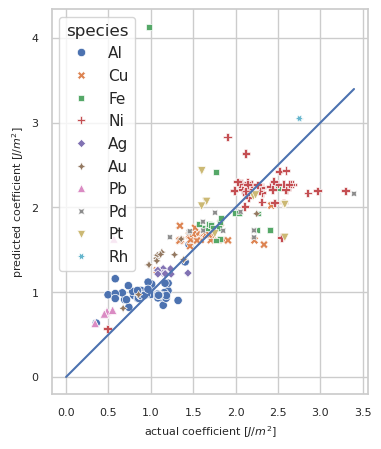

In [14]:
pred_vs_actual_plot(df_data)

# Make predictions from first-principles indicator properties

Now, we will import the DFT data that we will use with our model to make inferred predictions based on the indicator properties.

In [15]:
url_link = "https://github.com/bjasperson/property-covariance-demo/blob/main/data/gb_dft.csv?raw=true"
df_dft = pd.read_csv(url_link, index_col=0)
df_dft.head()

,species,bulk_modulus_fcc,c44_fcc,C11-C12,surface_energy_111_fcc,surface_energy_121_fcc,surface_energy_100_fcc,unstable_stack_energy_fcc,intr_stack_fault_energy_fcc,lattice_constant_fcc,relaxed_formation_potential_energy_fcc,vacancy_migration_energy_fcc,units,dft_exact_coeff
0,Ag,92.8612,41.2075,31.0503,0.044252,0.050806,0.049370,0.006472,0.001067,4.1457,0.7209,0.6564,"{‘bulk_modulus_unit_fcc’:’GPa’, ‘elastic_const...",1.032129
1,Al,76.0248,33.6604,53.4132,0.050868,0.059045,0.058608,0.010430,0.007602,4.0378,0.6413,0.3347,"{‘bulk_modulus_unit_fcc’:’GPa’, ‘elastic_const...",0.886213
2,Au,144.4053,26.5289,20.9309,0.043441,0.050244,0.054176,0.005418,0.001872,4.1539,0.2512,0.3986,"{‘bulk_modulus_unit_fcc’:’GPa’, ‘elastic_const...",0.842135
3,Cu,133.9783,79.5973,53.4236,0.080203,0.092686,0.090315,0.011104,0.002628,3.6239,0.8481,0.6623,"{‘bulk_modulus_unit_fcc’:’GPa’, ‘elastic_const...",1.551010
4,Ni,206.5840,117.5921,83.1221,0.114032,0.140808,0.139810,0.017851,0.008919,3.5036,1.2142,1.0189,"{‘bulk_modulus_unit_fcc’:’GPa’, ‘elastic_const...",2.302325


Filter your model performance list from above based on the DFT properties available, and select the top performing model.

In [16]:
def filter_model_results(df, dft_list):
    results = []
    for i, row in df.iterrows():
        factors = row.factors
        if all(factor in dft_list for factor in factors):
            results.append(row)
    return pd.DataFrame(results)

df_result_dft_only = filter_model_results(df_results, df_dft.columns.to_list())
df_result_dft_only.head()

,factors,num_factors,cv_score,cv_score_std
32,"[c44_fcc, unstable_stack_energy_fcc]",2,-0.264657,0.109752
14,"[lattice_constant_fcc, unstable_stack_energy_fcc]",2,-0.323444,0.057234
17,"[bulk_modulus_fcc, c44_fcc]",2,-0.351078,0.125372
31,"[c44_fcc, intr_stack_fault_energy_fcc]",2,-0.360189,0.114965
11,"[lattice_constant_fcc, c44_fcc]",2,-0.361008,0.112243


Make prediction from DFT indicator properties, compare with the "true" DFT coefficient (calculated separately).

In [17]:
# best model of the 5 available DFT properties
dft_model_properties = ['c44_fcc',  
                        'unstable_stack_energy_fcc'
                       ]

df_dft['dft_pred_coeff'] = add_pred(df_dft, 
                                    pipe,
                                    dft_model_properties,
                                    label="dft_exact_coeff")

below is from dft_import. Need to figure out what to roll in. Without prediction

In [18]:
def get_boxplot(df_ip, 
                df_dft, 
                plot_errorbar = True,
                order_list = ["Ag","Al","Au","Cu","Ni","Pd","Pt"]):
    """plot boxplot of dft GB results
    """
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=(4,3))
    sns.boxplot(data = df_ip, 
                x="species", 
                y="coeff", 
                order=order_list, 
                color = "0.8", 
                linewidth=1.0,
                fliersize=5.0,
                whis=0,
                flierprops={"marker":"."},
                zorder=1)
    ax.set_ylabel("GB scaling coefficient")

    # add dft Xs
    ax.scatter(df_dft['species'],
               df_dft['dft_pred_coeff'], 
               marker='x', 
               s=100., 
               alpha=1.0, 
               color="r",
               label='\n'.join(wrap(r"$E_0$ regression prediction using DFT indicator properties",20)),
               zorder=3)

    df_dft_gb_plot = df_dft[['species','dft_exact_coeff']].drop_duplicates()
    df_dft_gb_plot = df_dft_gb_plot[df_dft_gb_plot['species'].isin(order_list)]
    ax.scatter(df_dft_gb_plot['species'],
               df_dft_gb_plot['dft_exact_coeff'], 
               marker='<', 
               s=50., 
               alpha=0.9, 
               color="r",
               label='\n'.join(wrap(r"$E_0$ fit directly to DFT GB results",20)),
               zorder=2)

    # add errorbars if desired
    if plot_errorbar == True:
        ax.errorbar(df_dft['species'],
                    df_dft['regr_coeff'], 
                    yerr = (df_dft['regr_coeff_lower'],
                            df_dft['regr_coeff_upper']), 
                            fmt='.', 
                            markersize=0.0001, 
                            alpha=0.5, 
                            color="r",
                            #label='\n'.join(wrap("Predicted strength using DFT indicator properties",20)),
                            elinewidth=2.0,
                            capsize = 4)

    fig.legend(bbox_to_anchor = (0.05,0.9,0.85,.15),#(0.,1.02,1.,.102),
                    loc='lower left',
                    mode="expand",
                    ncol = 2,
                    fontsize= 8)

    return 

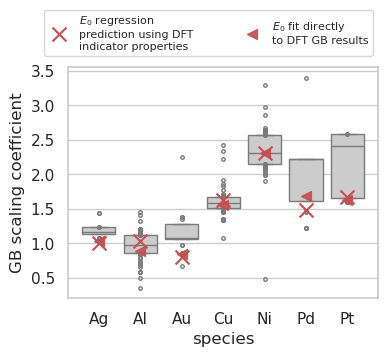

In [19]:
get_boxplot(df_data, df_dft, plot_errorbar=False)